Welcome to Day 4 of the Practicals !!

Today we will investicate how to study sequences of behaviours. In perticular, how to use Markov Chains (MCs) and Hidden Markov Models (HMMs) to analyse the statistics of how zebrafish reorient themselves during free swim.

The data we will be using comes from the paper : [Thermal modulation of Zebrafish exploratory statistics reveals constraints on individual behavioral variability, Le Goc et al. 2021, BMC Biol \[1\]](https://bmcbiol.biomedcentral.com/articles/10.1186/s12915-021-01126-w). In this paper, the authors analyse the statiscs of how larvae reorient themselves depending on the temperature of the water. As you know, zebrafish larvae move in sequences of discrete bouts. With each bout, the larvae will move forward and potentially reorient themselves. We want to understand this reorientation statistics.

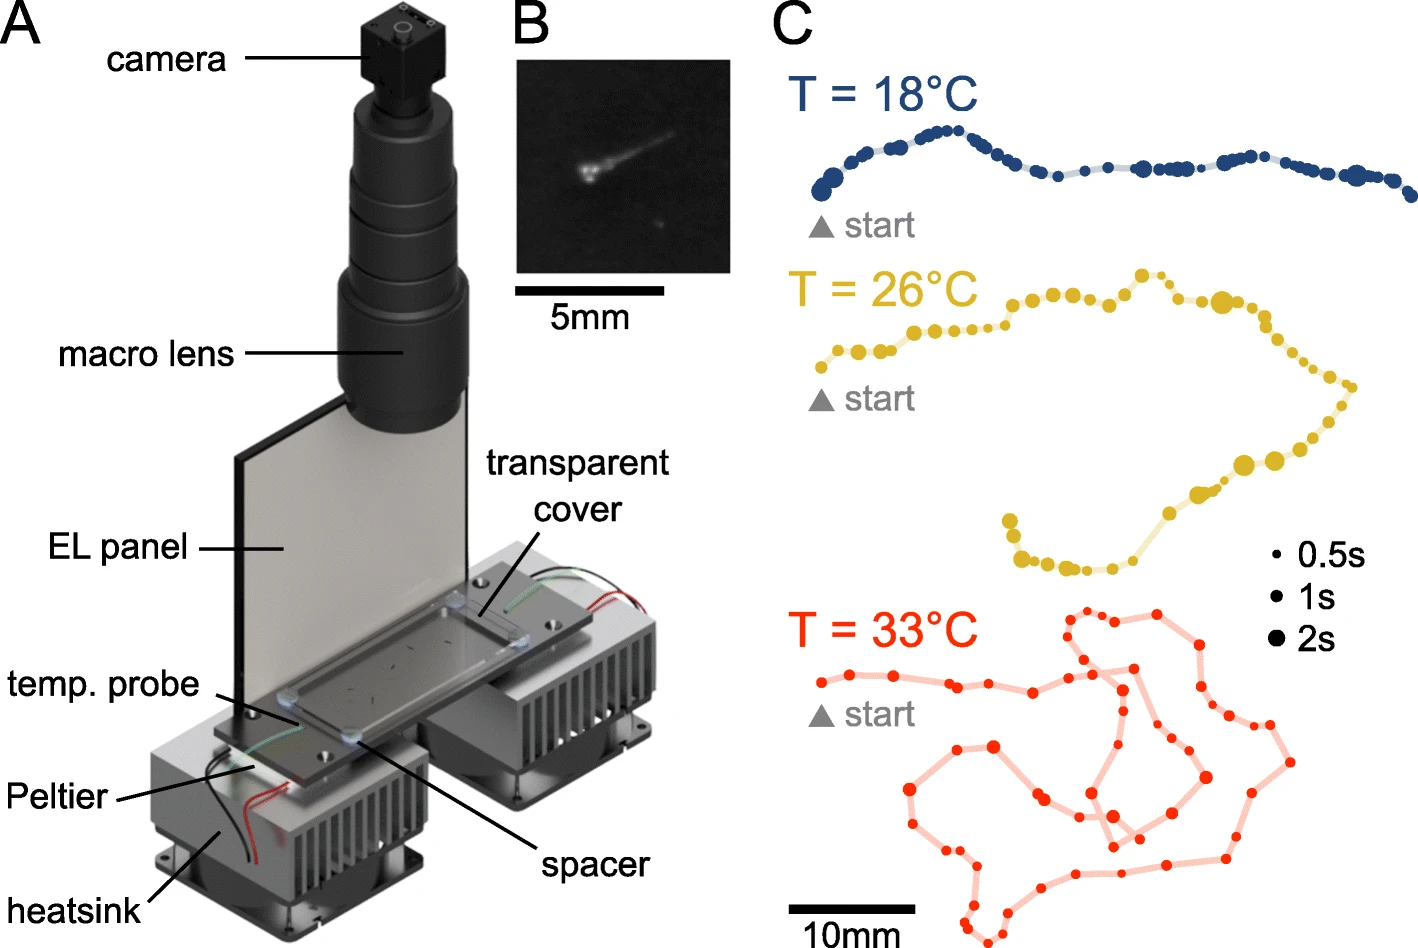

We will not reproduce the same analysis as [1], but simplify the basic ideas.

If you want to read more you can also look at [From behavior to circuit modeling of light-seeking navigation in zebrafish larvae, Karpenko et al. 2020, eLife \[2\]]( https://doi.org/10.7554/eLife.52882 ).

In [1]:
%load_ext autoreload
%autoreload 2

# Imports

As usual lets start by importing a few librairies and functions

In [670]:
import h5py
from Helper_Functions.accessing_data import h5tree_view
from Helper_Functions.ZBrain_contours import get_vals_from_ref
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.widgets import Slider
import numpy as np

# Making H5 from MatLaB file

# Get the data

And now lets load the data.

You will find it in the hdf5 file `banyuls_data/behaviour_free_swimming.h5`. Load this file and show the data tree. You will see that it is split into different temperature conditions (18°C → 33°C).

For each temperature, you have access to different datasets :
- `bouttime` : the time of each bout.
- `displacements` : the size of each bout.
- `dtheta` : the change in orientation/direction of this bout.
- `interboutintervals` : the time between bouts (i.e. how long the larva spent not moving).
- `xpos` : the X position of the larvae
- `ypos` : the Y position of the larvae

Each of those datasets 2D and structured `sequence x bout`. For example for 18°C, 532 trajectories of 1 fish were recorded, containing 642 bouts. ⚠️ However, not all 532 trajectories were imaged long enough to observe 642 bouts! So the 6 datasets mentionned above contain NaNs !! Be careful during this practical, and remember to deal with the NaNs appropriatly !

In [652]:
filename = "content/banyuls_data/behaviour_free_swimming.h5"
file = h5py.File(filename, "r")
h5tree_view(file)

. content/banyuls_data/behaviour_free_swimming.h5
├── 📁behaviour
│   ├── 🏷️framerate = `24.935128768196524`
│   └── 🏷️source = `https://bmcbiol.biomedcentral.com/articles/10.1186/s12915-021-01126-w`
│   ├── 📁18
│   │   └── 🏷️temperature = `18°C`
│   │   ├── 🔢bouttime ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢displacements ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢dtheta ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `degree`
│   │   ├── 🔢interboutintervals ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢xpos ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢ypos ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `mm`
│   ├── 📁22
│   │   └── 🏷️temperature = `22°C`
│   │   ├── 🔢bouttime ⚙️(1329, 749)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢displacements ⚙️(1329, 748)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢dtheta ⚙️(1329, 748)float64
│   │   │   └── 🏷️unit = `degree`
│   │   ├── 🔢interboutintervals ⚙️(1329, 74

# Observe the Data

Lets first focus on the data at 26°C. Load the data required bellow and plot an example fish trajectory.

In [656]:
data = file["/behaviour/26/"]

xs, ys = data["xpos"][:], data["ypos"]  # x and y positions 
dthetas = data["dtheta"][:]             # reorientation angles
dts = data["interboutintervals"][:]     # interbout intervals
distance = data["displacements"][:]     # distance traveled with each bout

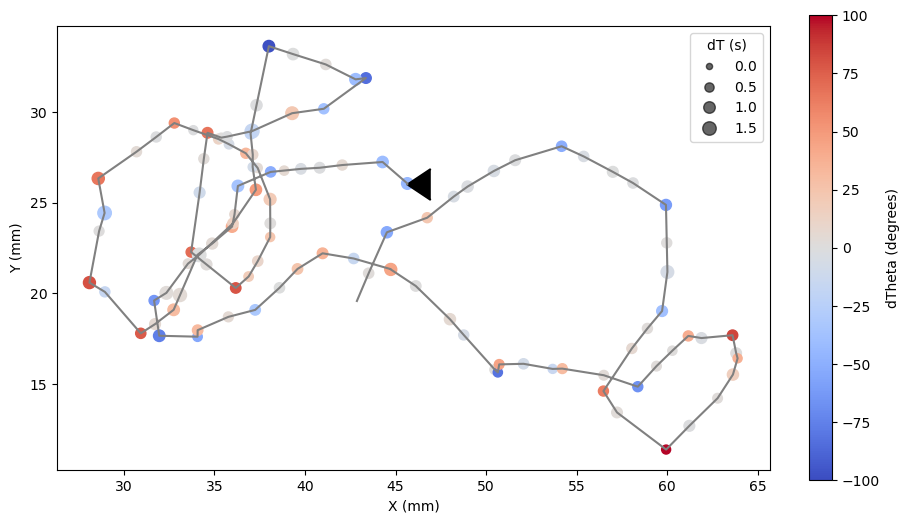

In [657]:
i = 1
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(xs[i], ys[i], color="grey")
h = ax.scatter(
    xs[i], ys[i], c=np.insert(dthetas[i],-1,0), 
    s=np.insert(np.nan_to_num(dts[i]), 0, 0)*50+20,
    cmap="coolwarm", vmin=-100, vmax=+100)
ax.scatter(xs[i,0], ys[i,0], marker=4, s=500, color="k")

fig.colorbar(h, ax=ax, label="dTheta (degrees)", fraction=0.03)
handles, labels = h.legend_elements(prop="sizes", alpha=0.6, num=5, func=lambda x: (x-20)/50)
legend2 = ax.legend(handles, labels, loc="upper right", title="dT (s)")

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_aspect("equal")

# Markov Chains

In the first part of this practical, we will :
1. manualy classify bouts to be one of 3 states : 'forward', 'left' or 'right'
2. find the Markovian statistics of those 3 states
3. see how those statistics evolve with temperature
4. find the stationary distribution of the Markov Chain
5. use the Markov Chain to generate new sequences of states 

In [658]:
cmap_states = ListedColormap(["k","b","r"]) # custom colormap for the 3 states : 'forward', 'left' or 'right'

In [678]:
def plot_transition_matrix(ax, T, labels=["forward", "left", "right"]):
    """Routine to plot transition matrices.
    
    Parameters :
    ------------
    ax : matplotlib.Axes
        matplotlib axis where to plot the transition matrix.
    T : 2D square array
        transition probability matrix.
    labels : list of strings
        labels for each state of the transition matrix.
        Must have the same lenght as :T:.
        default : ["forward", "left", "right"]
    """
    assert T.ndim==2, f":T: must be 2D. You gave {T.ndim}D."
    assert T.shape[0]==T.shape[1], f":T: must be a square matrix. You gave {T.shape}."
    assert ((T>=0) * (T<=1)).all(), f":T: must be a matrix of probabilities. Some values you gave were not between 0 and 1."
    h = ax.imshow(T.T, vmin=0, vmax=1, cmap="plasma", origin="lower", aspect="equal")
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            ax.text(i,j, f"{T[i,j]:0.2f}", ha="center", va="center")
    ax.set_xticks([0,1,2], labels)
    ax.set_yticks([0,1,2], labels)
    ax.set_xlabel("Current step")
    ax.set_ylabel("Next step")
    return h

## Classifying Bouts

Let's start by looking at the re-orientation angles. Every time the larvae make a bout, they reorient their body by a certain angle $\delta \theta$.
- if $\delta \theta \approx 0$ : they will essentialy be going forward.
- if $\delta \theta < 0$ : they will be going left.
- if $\delta \theta > 0$ : they will be going right.

Run the following cell to plot the histogram of $\delta \theta$. **👉⌨️Using the two sliders, can you find two thresholds which will define the 3 states : 'forward', 'left' and 'right' ?👉⌨️**

0

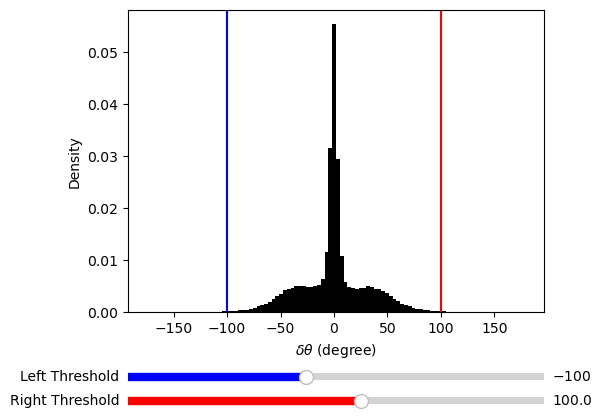

In [674]:
fig, ax = plt.subplots()
ax.hist(dthetas.ravel(), bins=100, color="k", density=True);
left_line = ax.axvline(-100, color=cmap_states.colors[1])
right_line = ax.axvline(+100, color=cmap_states.colors[2])
ax.set_xlabel(r"$\delta \theta$ (degree)")
ax.set_ylabel("Density")

fig.subplots_adjust(left=0.25, bottom=0.25)
# Make a horizontal slider to control the frequency.
axslidL = fig.add_axes([0.25, 0.1, 0.65, 0.03])
left_slider = Slider(
    ax=axslidL,
    label='Left Threshold',
    valmin=np.nanmin(dthetas),
    valmax=0,
    valinit=-100,
    color=cmap_states.colors[1]
)
axslidR = fig.add_axes([0.25, 0.05, 0.65, 0.03])
right_slider = Slider(
    ax=axslidR,
    label='Right Threshold',
    valmax=np.nanmax(dthetas),
    valmin=0,
    valinit=+100,
    color=cmap_states.colors[2]
)

def update(val):
    left_line.set_xdata([left_slider.val])
    right_line.set_xdata([right_slider.val])
    fig.canvas.draw_idle()

left_slider.on_changed(update)
right_slider.on_changed(update)

In [675]:
left, right = -10, +10 # the two thresholds you found

👉⌨️Now lets **write a function to classify bouts according to the thresholds.**

It should take $\delta \theta$s and return :
- 0 for 'forward'
- 1 for 'left'
- 2 for 'right'

In [689]:
def bout_classifier(dtheta_seqs, left_threshold, right_threshold):
    """Classify reorientation angles into 3 states based on 2 thresholds.

    Reorientation angle δθ are classifed as followed :
        - δθ < :left_threshold:  → 1
        - δθ > :right_threshold: → 2
        - :left_threshold: < δθ < :right_threshold: → 0
        - δθ = NaN → -1
    ⚠️ Be carefull of the NaNs !! 
    
    Parameters :
    ------------
    dtheta_seqs : array
        sequences of reorientation angles
    left_threshold : number
        lower threshold
    right_threshold : number
        upper threshold

    Returns :
    ---------
    bout_seqs : array of integers
        sequence of states.
    """
    idx_left = np.where(dtheta_seqs < left_threshold)
    idx_right = np.where(dtheta_seqs > right_threshold)
    bout_seqs = np.zeros_like(dtheta_seqs, dtype=np.int8)
    bout_seqs[idx_left] = 1
    bout_seqs[idx_right] = 2
    bout_seqs[~np.isfinite(dtheta_seqs)] = -1

    assert bout_seqs.shape == dtheta_seqs.shape, ":bout_seqs: should have the same shape as :dtheta_seqs:."
    assert "int" in bout_seqs.dtype.name, ":bout_seqs: should be an array of integers."
    return bout_seqs

Let's apply your classification function to the data

In [694]:
bouts = bout_classifier(dthetas, left, right)

Now, let's plot the histograms of reorientation angles for each state to check that our classification worked.

Text(0, 0.5, 'Density')

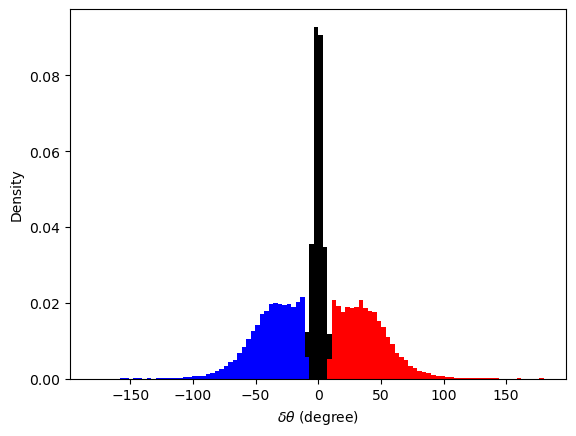

In [695]:
fig, ax = plt.subplots()
for s in range(3):
    ax.hist(dthetas[bouts==s], bins=100, range=[-180, +180],density=True, color=cmap_states.colors[s]);
ax.set_xlabel(r"$\delta \theta$ (degree)")
ax.set_ylabel("Density")

And let's see what it looks like for an example sequence

Text(0, 0.5, '$\\delta \\theta$ (degree)')

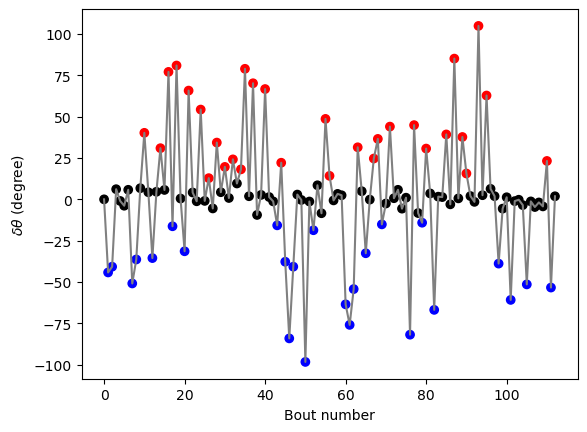

In [696]:
i=1
x = np.arange(len(dthetas[i]))
fig, ax = plt.subplots()
ax.plot(x, dthetas[i], color="grey")
ax.scatter(x, dthetas[i], c=bouts[i], cmap=cmap_states)
ax.set_xlabel("Bout number")
ax.set_ylabel(r"$\delta \theta$ (degree)")

## Bout Probabilities and transitions

Now that we have classifed the bouts into 3 possible states, we can define a Markov Chain to study the statistics of those states and the transitions between those states.

**A quick reminder on Markov Chains (MCs)** 

The idea of a MC is that the next state is only determined from the current state. This is done through the Transition Matrix which gives you the probabilities of all possible next states, given the current state. So in effect, it is a system which has no memory.

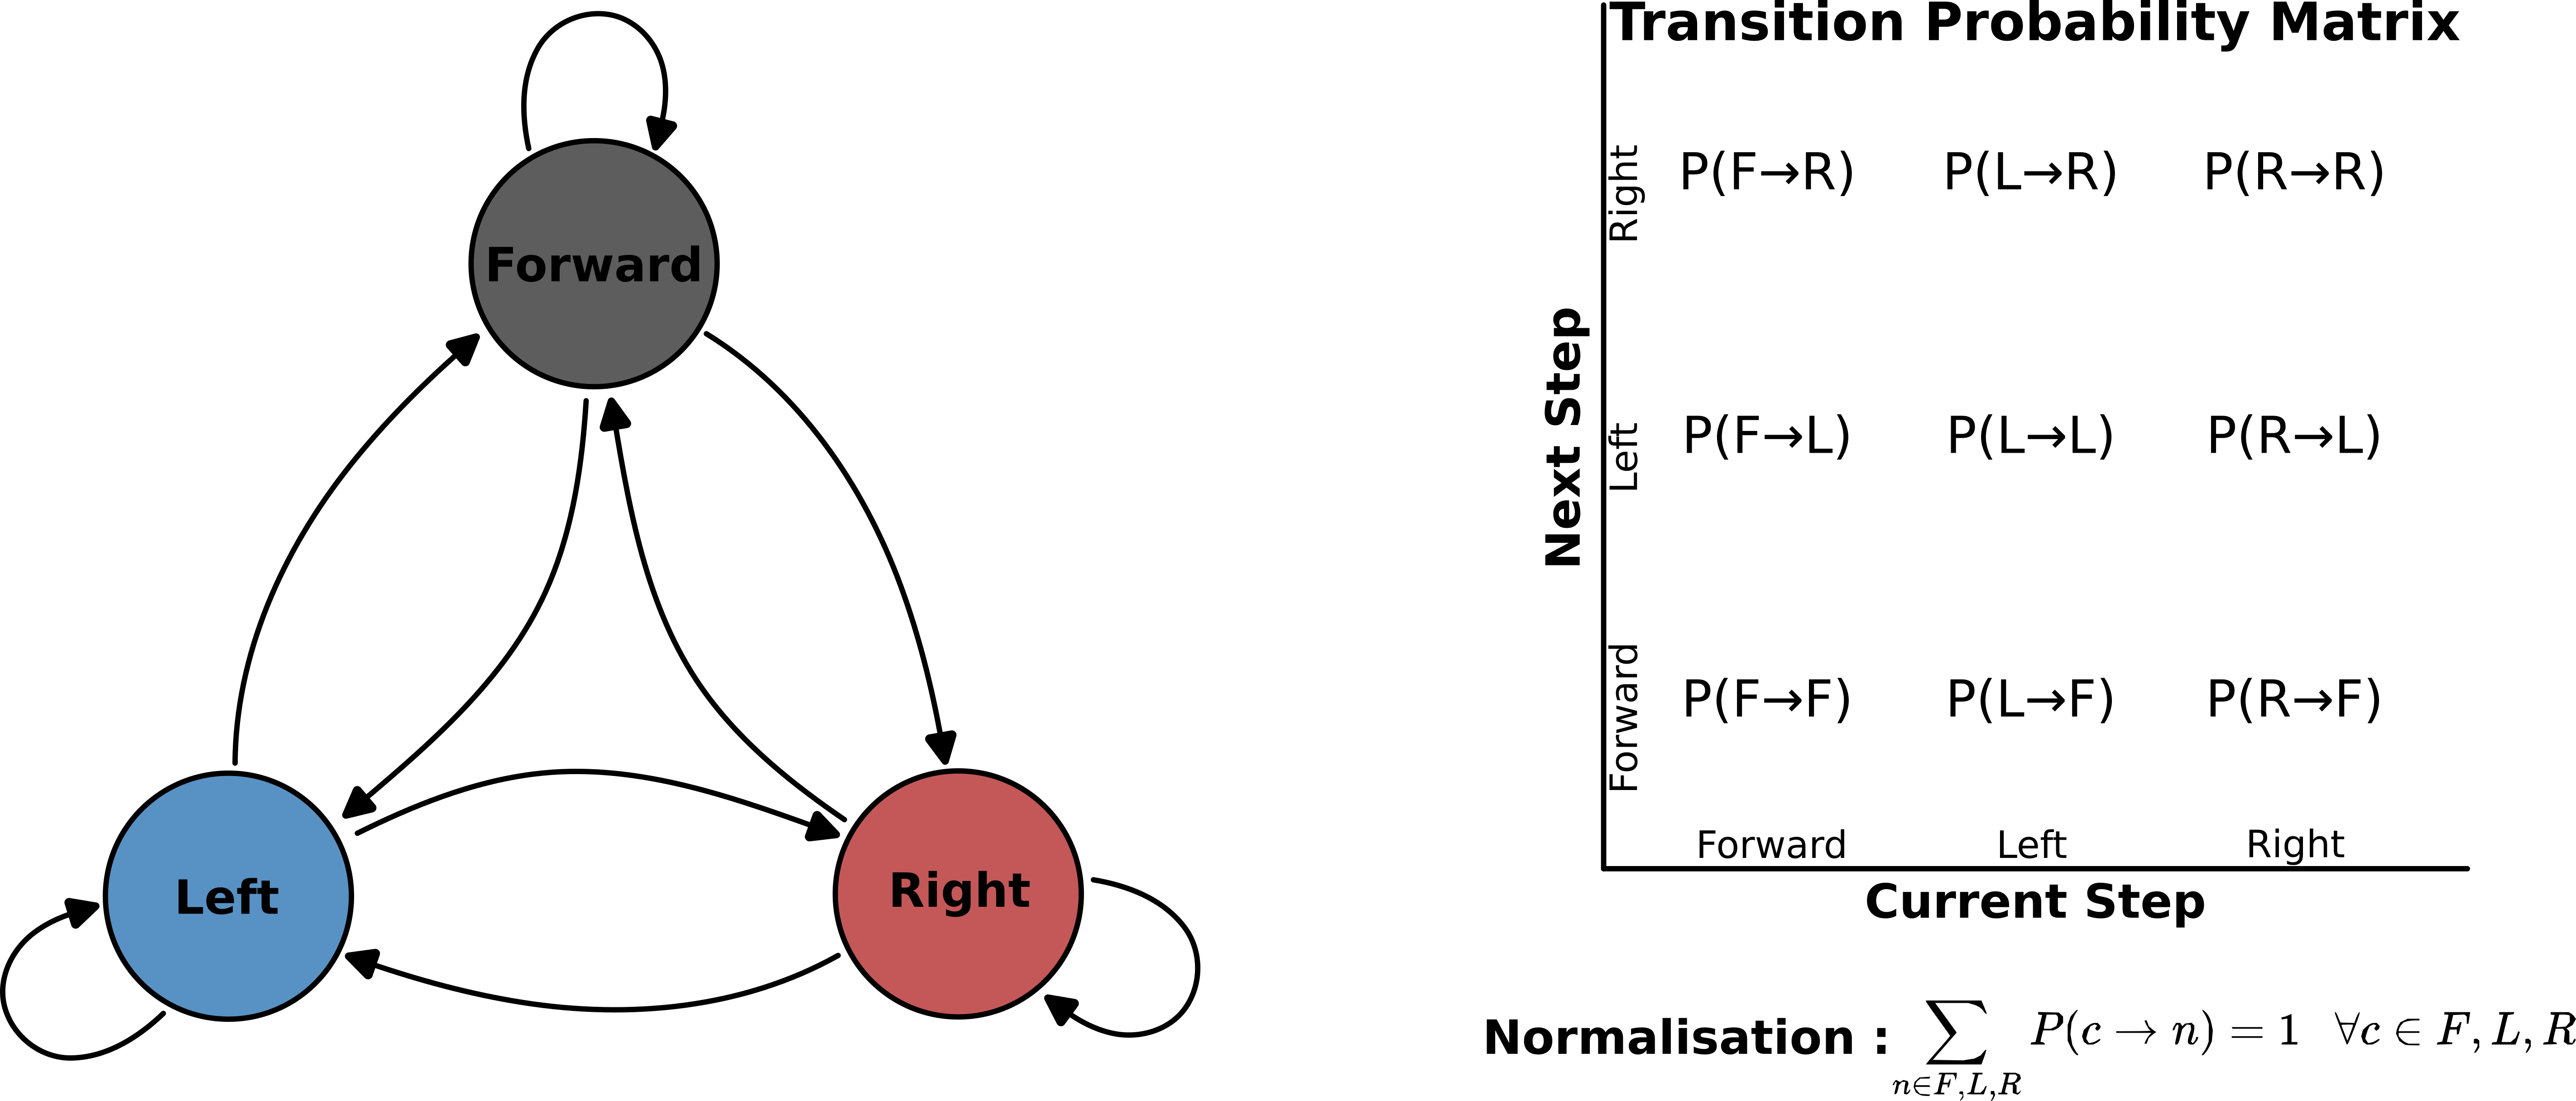

We will start by first creating a function which computes the *a priori* probability of each state from the data : $$P(s)\ ,\ s\in{F,L,R}$$

In [706]:
def bout_proba(bout_seqs):
    """Compute the a priori probability of each state.

    💡 you can use the function np.unique(X, return_counts=True) to count 
    the occurence of every unique item in an array.

    ⚠️ the input might contain values -1 (remember the previous exercise). 
    Your function should work with and without those -1 values !
    
    Parameters :
    ------------
    bout_seqs : array of integers
        sequence of states. 0='Forward', 1='Left', 2='Right', -1=NaN

    Returns :
    ---------
    p_bout : array of 3 float
        probability of each state 'Forward', 'Left', 'Right'
    """
    types, count = np.unique(bout_seqs, return_counts=True)
    if -1 in types:
        n_bout = count[1:]
    else:
        n_bout = count
    n_tot = n_bout.sum()
    p_bout = n_bout/n_tot
    
    assert p_bout.ndim == 1, ":p_bout: should be a 1d array with 3 floats."
    assert len(p_bout)==3, ":p_bout: should be a 1d array with 3 floats."
    assert p_bout.sum() == 1, ":p_bout: is a probability array. It should be normalised to 1."
    return p_bout

Let's apply this function to our sequence of bouts to see the $P(s)$

In [707]:
p_bouts = bout_proba(bouts)
p_bouts

array([0.50496375, 0.25018405, 0.2448522 ])

As $P(s)$ is the *a priori* probability of being in each state, $\sum_{s\in{F,L,R}}P(s)=1$. Check that this is true of `p_bouts`

In [709]:
p_bouts.sum() == 1

True

Now we will create a function to compute the Transition Probability Matrix.

This is a bit more complicated than $P(s)$.

In [741]:
def bout_transition(bout_seqs):
    """Compute the transition probability matrix from sequences of bouts.

    💡 you need to look at each sequence one by one. For each bout, identify
    the next bout, this gives you the transition, and record the total 
    number of times you have seen each transition. You will then need to
    normalise the matrix correctly.

    ⚠️ the input might contain values -1 (remember the previous exercise). 
    Your function should work with and without those -1 values !
    
    Parameters :
    ------------
    bout_seqs : 2D array of integers, shape (sequence x bouts)
        sequences of states. 0='Forward', 1='Left', 2='Right', -1=NaN

    Returns :
    ---------
    P : 2D array of shape (3,3)
        probability of transition between each state 'Forward', 'Left' and 'Right'.
    """
    T = np.zeros((3,3), dtype=np.int_)
    for s,seq in enumerate(bout_seqs):
        for i in range(len(seq)-1):
            j = i+1
            if seq[j] == -1:
                break
            T[seq[i], seq[j]] += 1
    P = T / T.sum(axis=1)[:,np.newaxis]
    assert P.shape == (3,3), ":P: should be a 2D matrix of shape 3x3."
    assert np.isclose(P.sum(axis=1), 1).all(), ":P: is not normalised properly."
    return P

Let's apply this function to our sequence of bouts

In [727]:
T_bouts = bout_transition(bouts)
T_bouts

array([[0.48783171, 0.25741996, 0.25474833],
       [0.51556403, 0.31468373, 0.16975225],
       [0.52419168, 0.17214826, 0.30366006]])

As the transition matrix gives you the probability of going to the next state $n$ from the current state $c$ : $P(c→n)$, it should have the following normalisation : $$\sum_{n\in{F,L,R}}P(c→n)=1\ \ \forall c$$
Check that this is the case for `T_bouts`

In [719]:
(T_bouts.sum(axis=1)==1).all()

True

Now that was had work ! 😮‍💨😮‍💨  Well Done !! 😃 

As a reward, here is a plot of what we have found so far : 

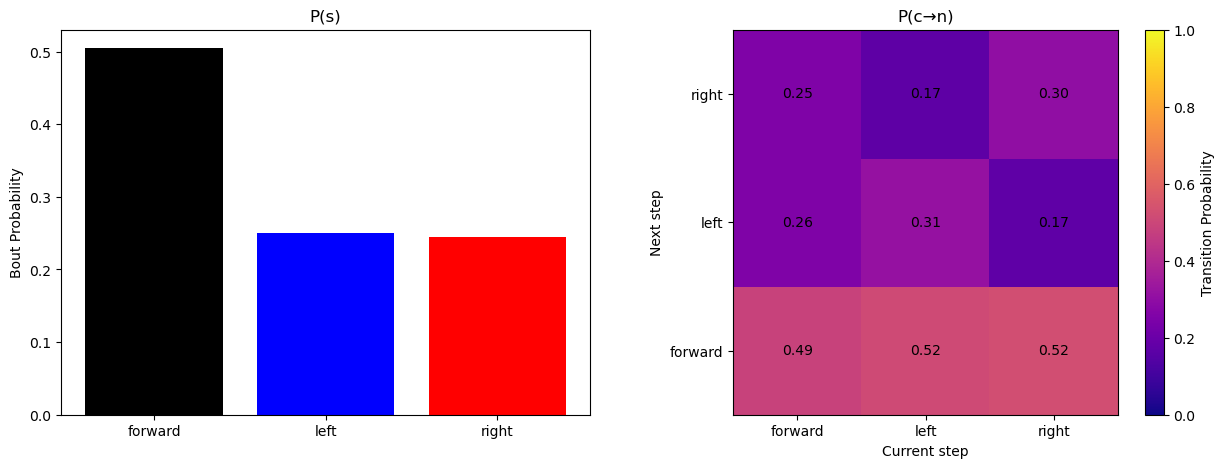

In [731]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

ax = axs[0]
ax.set_title(r"P(s)")
ax.bar([0,1,2], p_bouts, color=cmap_states.colors)
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_ylabel("Bout Probability")


ax = axs[1]
ax.set_title(r"P(c→n)")
h = plot_transition_matrix(ax, T_bouts)
fig.colorbar(h, ax=ax, label="Transition Probability")

Spend a bit of time interpreting those 2 graphs. What do they tell you about the re-orientation dynamics of the larvae ?

## Comparing Different temperatures

Now that we have seen how to classify the bouts, compute $P(s)$ and $P(c→n)$ for the dataset at 26°C, we will do the same for the other temperatures.

In [732]:
Temperatures = [18,22,26,30,33]

Use the 3 function you wrote earlier to compute $P(s)$ and $P(c→n)$ for each temperature.

Store the results in 2 array :
- `p_alltemp` of shape (temperatures x 3)
- `T_alltemp` of shape (temperatures x 3 x 3)

In [742]:
p_alltemp = np.empty((len(Temperatures), 3))
T_alltemp = np.empty((len(Temperatures), 3, 3))
for t,T in enumerate(Temperatures):
    dthetas = file[f"/behaviour/{T}/dtheta"][:]
    bouts = bout_classifier(dthetas, left, right)
    p_alltemp[t] = bout_proba(bouts)
    T_alltemp[t] = bout_transition(bouts)

Now we will plot how $P(s)$ varies with temperature

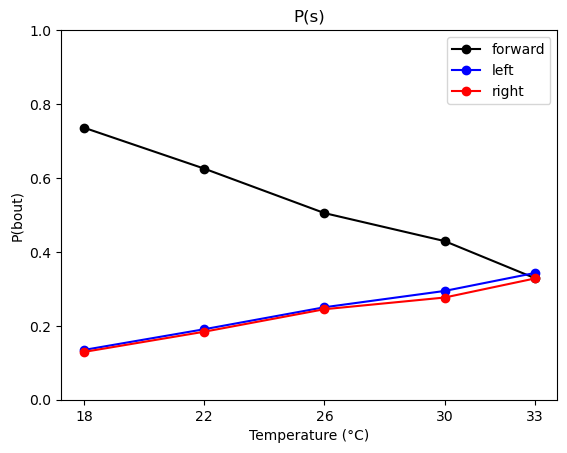

In [744]:
fig, ax = plt.subplots()
ax.plot(Temperatures, p_alltemp[:,0], "-o", color=cmap_states.colors[0], label="forward")
ax.plot(Temperatures, p_alltemp[:,1], "-o", color=cmap_states.colors[1], label="left")
ax.plot(Temperatures, p_alltemp[:,2], "-o", color=cmap_states.colors[2], label="right")
ax.set_ylim(0,1)
ax.set_xticks(Temperatures)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("P(bout)")
ax.set_title(r"P(s)")
ax.legend()

And now how $P(c→n)$ varies with temperature.

Text(0.5, 1.0, 'P(c→n)')

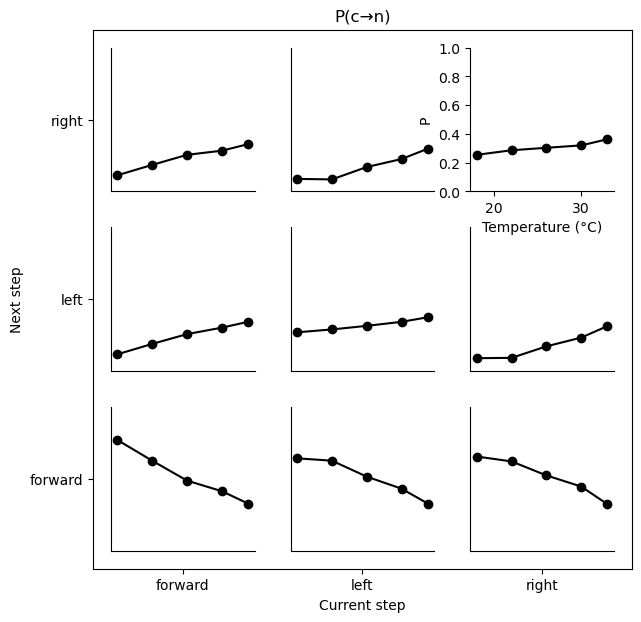

In [745]:
fig, ax = plt.subplots(figsize=(7,7))
#h = ax.imshow(T_bouts.T, vmin=0, vmax=1, cmap="plasma", origin="lower")
for i in range(3):
    for j in range(3):
        axin = ax.inset_axes([i-0.4, j-0.4, 0.8, 0.8], transform=ax.transData)
        if (i,j) != (2,2):
            axin.set_xticks([])
            axin.set_yticks([])
        else:
            axin.set_xlabel("Temperature (°C)")
            axin.set_ylabel("P")
        axin.spines['right'].set_visible(False)
        axin.spines['top'].set_visible(False)
        axin.set_ylim(0,1)
        axin.plot(Temperatures, T_alltemp[:,i,j], "-o",color="k")
#        ax.text(i,j, f"{T_bouts[i,j]:0.2f}", ha="center", va="center")
        
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_yticks([0,1,2], ["forward", "left", "right"])
ax.set_xlabel("Current step")
ax.set_ylabel("Next step")
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-0.5,2.5)
ax.set_aspect("equal")
ax.set_title(r"P(c→n)")

How do you interpret those results ? What does this mean for the larvae behaviour ?

## Stationary Distriution

An important property of a Markov Chain is its stationary distribution $\pi_s$. I this section we will compute it using 2 different methods, and compare it to the $P(s)$ we computed from the data.

**First lets have a quick reminder about Stationary Distributions (SDs) :**

The SD of a MC can be seen as the steady state regime of that MC. It is the probability of states $\pi = [P(s_1), ..., P(s_n)] = [\pi_{s_1}, ...\pi_{s_n}]$ which will not change given the transition matrix $T$. Mathematicaly this is expressed as $$\pi T = \pi$$

**Why is it useful to know $\pi_s$ ?**  
Well it tells you that, whatever your initial state, over the long run, the Markov Chain will be in state $s$ with a probability $\pi_s$.

**How do you find $\pi_s$ ?**  
There are 2 methods :
1. solve the equation $\pi T = \pi$ to find $\pi$. This will give you a quasi-exact solution, but can be quite math intensive
2. by mutiplying $T$ with itself $n$ times, you are computing the transition probability from the current step to n steps in the future $T^n = T\times T\times...\times T$. It can be shown that when $n→\infty$, $T^n_c = \pi\ \ \forall c$.

Don't worry if this is not clear yet, we will use both methods down bellow and you will understand.

Lets start with method 1. solving $\pi T = \pi$

In [746]:
eigenvals, eigenvects = np.linalg.eig(T_bouts.T) # find eigen of matrix

In [752]:
close_to_1_idx = np.isclose(eigenvals,1)              # find the eigen value which is close to 1
target_eigenvect = eigenvects[:,close_to_1_idx][:,0]  # find the respective eigen vector

In [754]:
pi_1 = target_eigenvect / sum(target_eigenvect) # normalise the eigen vector vector to get a probability
pi_1

array([0.50371241, 0.25085664, 0.24543095])

now let's check that `pi_1` is indeed the stationary distribution of `T_bouts`

In [755]:
pi_1@T_bouts - pi_1

array([-1.11022302e-16,  0.00000000e+00,  5.55111512e-17])

Now let's try method 2 : computing $T^n$

💡 you can use the function `np.linalg.matrix_power` to raise a array to a power

In [756]:
T_power = np.linalg.matrix_power(T_bouts,30)

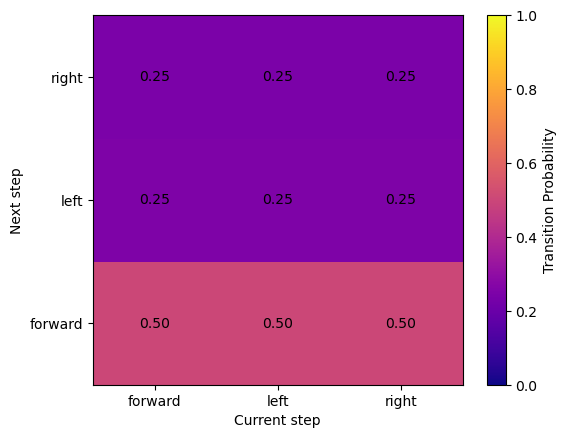

In [757]:
fig, ax = plt.subplots()
h = plot_transition_matrix(ax, T_power)
fig.colorbar(h, ax=ax, label="Transition Probability")

As you can see, if you choose $n$ big enoug all the columns of `T_power` are the same. Lets isolate one column as `pi_2` and check that it is indeed a stationary distribution of `T_bouts`

In [759]:
pi_2 = T_power[0]
pi_2

array([0.50371241, 0.25085664, 0.24543095])

In [760]:
pi_2@T_bouts - pi_2

array([ 0.00000000e+00, -5.55111512e-17,  2.77555756e-17])

Now compare `pi_1`, `pi_2` and `p_bouts`. What can you conclude ? 

In [761]:
pi_1

array([0.50371241, 0.25085664, 0.24543095])

In [762]:
pi_2

array([0.50371241, 0.25085664, 0.24543095])

In [763]:
p_bouts

array([0.50496375, 0.25018405, 0.2448522 ])

In [46]:
p_bouts@T_bouts - p_bouts

array([-0.00129104,  0.00068343,  0.00060761])

## Generate a sequence of bouts

In [52]:
def rand_state_from_proba(pbouts, n=None):
    return np.random.choice(np.arange(len(pbouts)), p=pbouts, size=n)

In [65]:
_, count = np.unique(rand_state_from_proba(p_bouts, n=1000000), return_counts=True)
np.isclose(p_bouts, count/count.sum(), rtol=1.e-3, atol=1.e-3).all()

True

In [66]:
def generate_sequence(N, p, T):
    seq = np.empty(N, dtype=np.int_)
    start = rand_state_from_proba(p)
    seq[0] = start
    for i in range(1,N):
        seq[i] = rand_state_from_proba(T[seq[i-1]])
    return seq

In [67]:
sequence = generate_sequence(10000,p_bouts, T_bouts)

Text(0.5, 1.0, 'Transition Matrix')

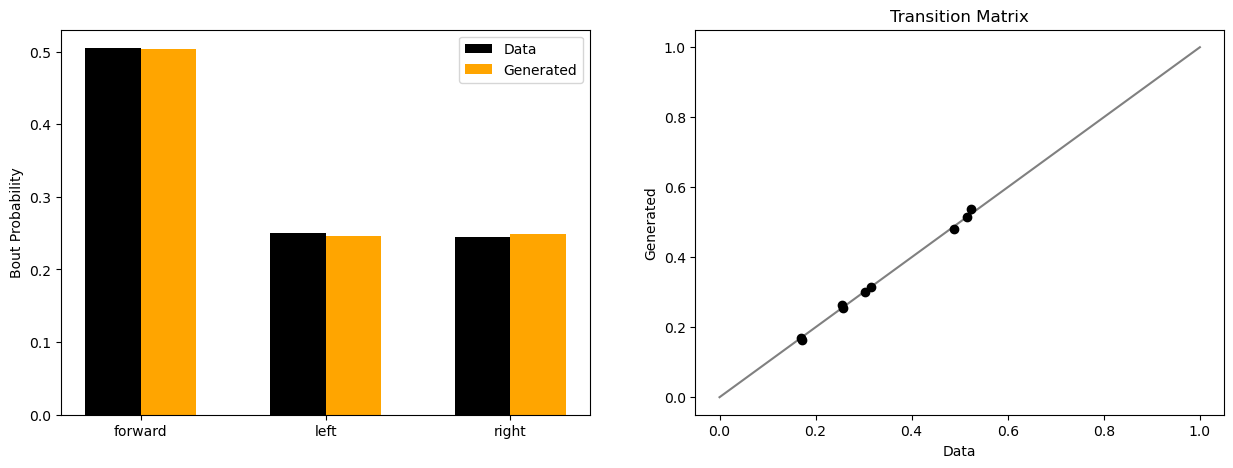

In [68]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

ax = axs[0]
width = 0.3
x = np.arange(3)
ax.bar(x-width/2, p_bouts, width, label="Data", color="k")
ax.bar(x+width/2, bout_proba(sequence), width, label="Generated", color="orange")
ax.legend()
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_ylabel("Bout Probability")

ax = axs[1]
ax.plot([0,1], [0,1], color="grey", zorder=0)
ax.scatter(T_bouts, bout_transition([sequence]), color="k")
ax.set_xlabel("Data")
ax.set_ylabel("Generated")
ax.set_title("Transition Matrix")

In [69]:
sequence = generate_sequence(100,p_bouts, T_bouts)

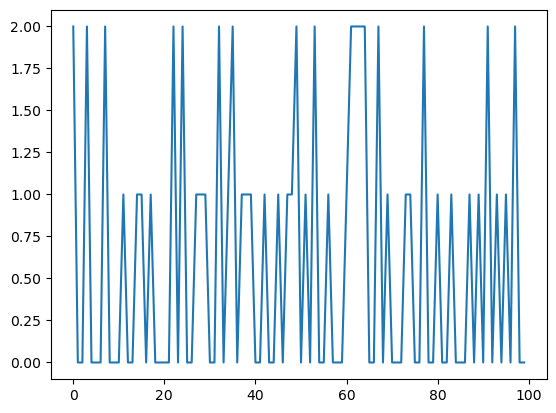

In [71]:
plt.plot(sequence)

# (optional) Gaussian Mixture

In [639]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

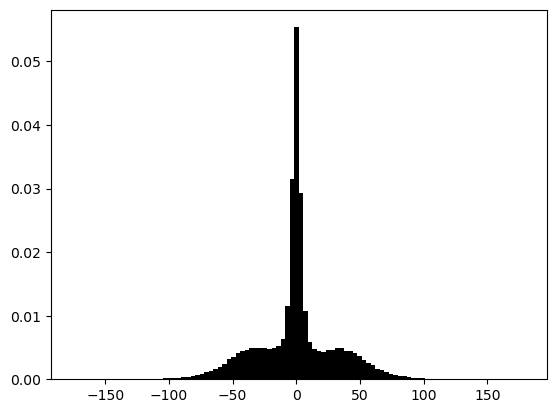

In [640]:
fig, ax = plt.subplots()
ax.hist(dthetas.ravel(), bins=100, color="k", density=True, stacked=True);

In [641]:
gm = GaussianMixture(n_components=3, means_init=np.array([[0],[-40],[+40]]))
gm.fit(dthetas[np.isfinite(dthetas)][:,np.newaxis])

GaussianMixture(means_init=array([[  0.],
       [-40.],
       [ 40.]]),
                n_components=3)

In [642]:
gm.means_

array([[ -0.03557078],
       [-29.10067204],
       [ 30.41494785]])

In [643]:
gm.covariances_

array([[[ 11.53673374]],

       [[690.46914695]],

       [[709.43172036]]])

In [644]:
np.sqrt(gm.covariances_)

array([[[ 3.39657677]],

       [[26.27677962]],

       [[26.63515948]]])

In [645]:
gm.covariances_[1,0]

array([690.46914695])

In [646]:
x = np.linspace(np.nanmin(dthetas), np.nanmax(dthetas), 1000)

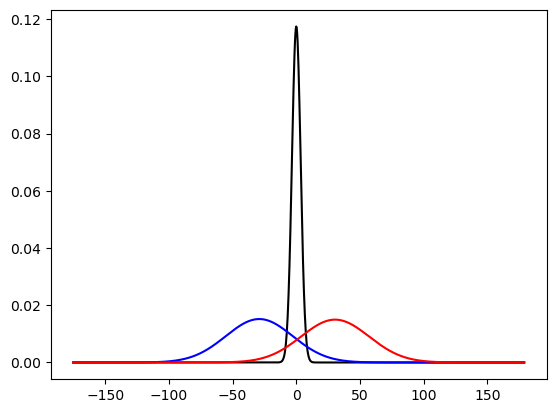

In [647]:
plt.plot(x, norm(loc=gm.means_[0], scale=np.sqrt(gm.covariances_[0,0])).pdf(x), color=cmap_states.colors[0])
plt.plot(x, norm(loc=gm.means_[1], scale=np.sqrt(gm.covariances_[1,0])).pdf(x), color=cmap_states.colors[1])
plt.plot(x, norm(loc=gm.means_[2], scale=np.sqrt(gm.covariances_[2,0])).pdf(x), color=cmap_states.colors[2])

<BarContainer object of 500 artists>

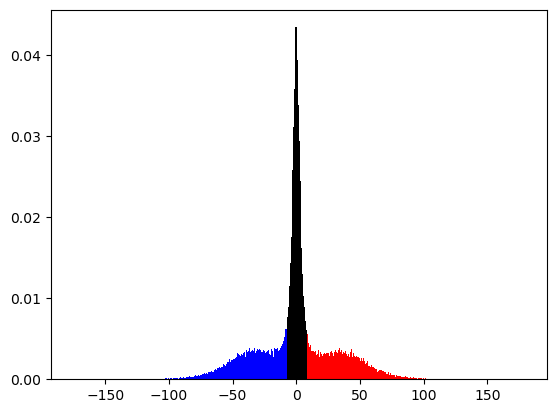

In [651]:
h, bins = np.histogram(dthetas[np.isfinite(dthetas)], bins=500)
h = h/h.sum()
predicted = gm.predict(bins[:,np.newaxis])
colors = [{p<0.5:cmap_states.colors[0], 0.5<=p<=1.5: cmap_states.colors[1], p>1.5: cmap_states.colors[2]}[True] for p in predicted]
fig, ax = plt.subplots()
ax.bar(bins[:-1], h, width=np.diff(bins), align="edge", color=colors)

# Hidden Markov Model

In [89]:
from hmmlearn import hmm

## preparing the data

In [90]:
sequences = [seq[np.isfinite(seq)] for seq in dthetas]
lenghts = [len(seq) for seq in sequences]
long_seq = np.concatenate(sequences)
long_seq.shape

(48693,)

## Preparing the Model

In [650]:
model = hmm.GaussianHMM(
    n_components=3, 
    covariance_type="spherical", 
    init_params="",
    params="mc",
    algorithm='viterbi',
)

model.startprob_ = p_bouts
model.transmat_ = T_bouts
model.means_ = np.array([[0], [-38], [+38]])#np.array([[0], [-46], [+46]])
model.covars_ = np.array([[20],[900],[900]])#np.array([[60],[650],[650]])

In [295]:
model.fit(long_seq[:,np.newaxis], lenghts)

GaussianHMM(covariance_type='spherical', init_params='', n_components=3,
            params='mc')

In [296]:
dths, bs = model.sample(10000)

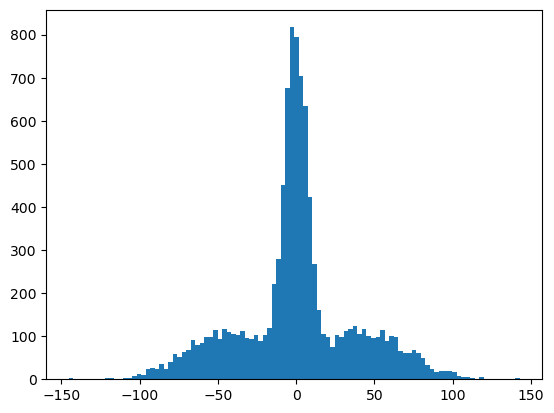

In [297]:
plt.hist(dths.ravel(), bins=100);

In [298]:
bs

array([2, 2, 0, ..., 2, 0, 2])

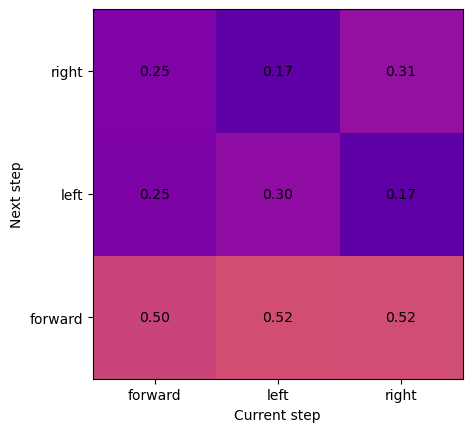

In [299]:
fig, ax = plt.subplots()
plot_transition_matrix(ax, bout_transition([bs]))

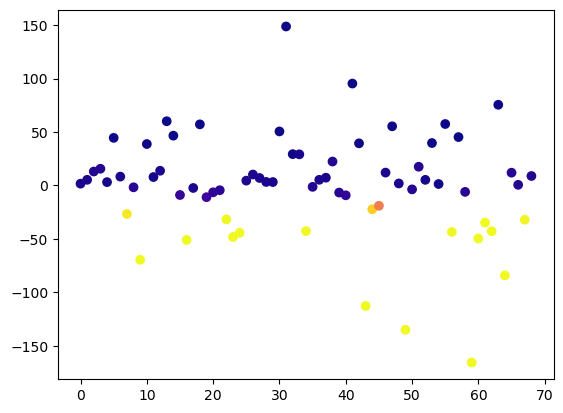

In [300]:
plt.scatter(
    np.arange(len(sequences[0])), 
    sequences[0], 
    c=model.predict_proba(sequences[0][:,np.newaxis])[:,1],
    vmin=0,
    vmax=1,
    cmap="plasma"
)

In [158]:
model.get_stationary_distribution()

array([0.23759261, 0.39212531, 0.37028208])

In [159]:
model.means_

array([[ -0.10916755],
       [-37.05899662],
       [ 37.31811481]])

In [160]:
model.covars_

array([[[ 17.87620851]],

       [[957.62897411]],

       [[943.90557662]]])

In [161]:
p_turn_flip(model.transmat_)

(0.755364957927567, 0.43084007653714)

In [201]:
def MSR_q(seq, q):
    if len(seq) < 2*q:
        return np.nan
    a = 0
    for i in range(1,q-1):
        a += (q-i) * np.corrcoef(sequences[0][:-1], np.roll(sequences[0], -1)[:-1])[0,1]
    return (q + 2*a) * (seq**2).mean()

def MSR(seq, qs):
    res = np.empty_like(qs, dtype=np.float_)
    for i,q in enumerate(qs):
        res[i] = MSR_q(seq, q)
    return res

In [202]:
MSR_q(sequences[0], 6)

20400.5906554468

In [218]:
qs = np.arange(0,15)
MSRS = np.empty((len(sequences),len(qs)), dtype=np.float_)
for i in tqdm(range(len(sequences))):
    MSRS[i] = MSR(sequences[i], qs)

100%|████████████████████████████████████████████████████| 1068/1068 [00:06<00:00, 169.20it/s]


In [220]:
MSR_mean = np.nanmean(MSRS, axis=0)
MSR_std = np.nanstd(MSRS, axis=0)

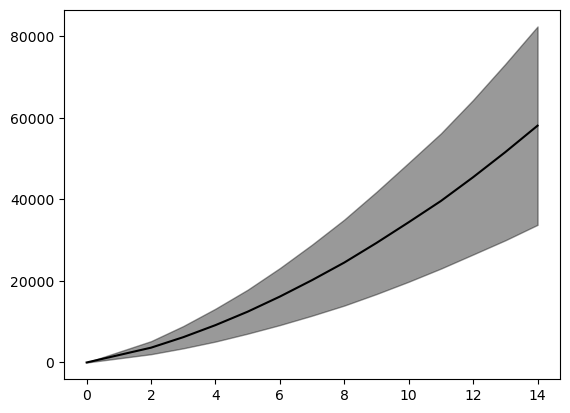

In [227]:
plt.plot(qs, MSR_mean, color="k")
plt.fill_between(qs, MSR_mean-MSR_std, MSR_mean+MSR_std, alpha=0.4, color="k")

In [313]:
rand_seq = gen_angles#np.random.choice(long_seq, size=10000)
#rand_seq = np.random.normal(scale=42,size=10000)

In [314]:
MSR_rand = MSR(rand_seq, qs)

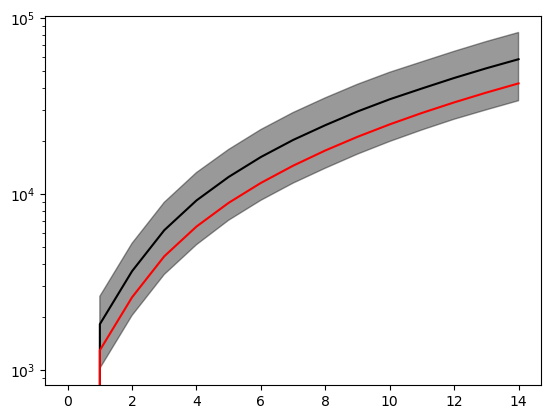

In [315]:
plt.plot(qs, MSR_mean, color="k")
plt.fill_between(qs, MSR_mean-MSR_std, MSR_mean+MSR_std, alpha=0.4, color="k")
plt.plot(qs, MSR_rand, color="r")
plt.yscale("log")

In [599]:
gen_angles, gen_states = model.sample(n_samples=50)

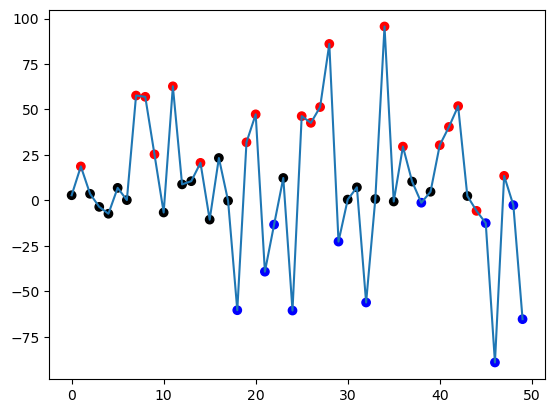

In [600]:
plt.plot(gen_angles)
plt.scatter(np.arange(len(gen_angles)), gen_angles, c=gen_states, cmap=cmap_states)

In [607]:
def reconstruct_trajs(dthets):
    angles = np.cumsum(np.deg2rad(dthets))
    dists = np.random.choice(distance[np.isfinite(distance)], size=len(dthets))
    dxy =  dists[:,np.newaxis]* np.c_[np.cos(angles), np.sin(angles)]
    x,y = tuple(np.cumsum(dxy, axis=0).T)
    return x, y

In [608]:
x, y = reconstruct_trajs(gen_angles)

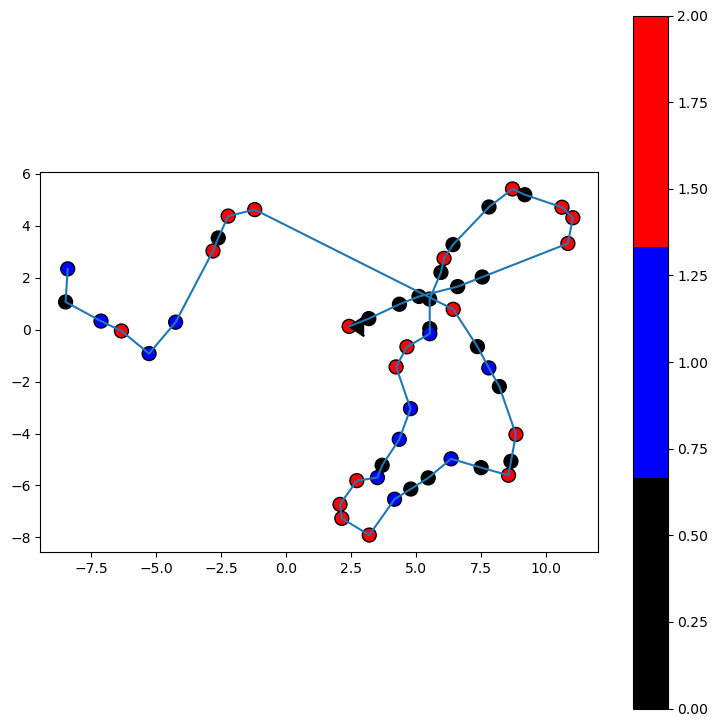

In [609]:
fig, ax = plt.subplots(figsize=(9,9))
ax.plot(x,y)
h = ax.scatter(x, y, c=np.insert(gen_states[1:], -1,0), cmap=cmap_states, edgecolors="k", s=100)
ax.scatter(x[0], y[0], marker=4, s=200, color="k")
fig.colorbar(h, ax=ax)
ax.set_aspect("equal")

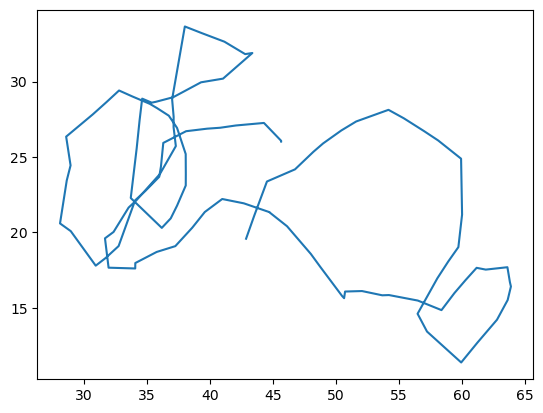

In [505]:
plt.plot(xs[1], ys[1])

In [623]:
cmap_states.colors[0]

'k'

In [292]:
model.fit(dtheta[:,np.newaxis])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0a176f9750>
Traceback (most recent call last):
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Model is not converging.  Current: -406280.3054911075 is not greater than -185131.52686903047. Delta is -221

GaussianHMM(means_prior=array([0, 0, 0]), n_components=3)

In [293]:
model.monitor_.converged

True

In [294]:
model.means_

array([[-0.03706996, -0.03706996, -0.03706996],
       [-6.12474967, -6.12474967, -6.12474967],
       [ 5.9324199 ,  5.9324199 ,  5.9324199 ]])

In [295]:
np.sqrt(model.covars_)

array([[[ 6.74745243,  0.        ,  0.        ],
        [ 0.        ,  6.74745243,  0.        ],
        [ 0.        ,  0.        ,  6.74745243]],

       [[17.54476124,  0.        ,  0.        ],
        [ 0.        , 17.54476124,  0.        ],
        [ 0.        ,  0.        , 17.54476124]],

       [[17.91017874,  0.        ,  0.        ],
        [ 0.        , 17.91017874,  0.        ],
        [ 0.        ,  0.        , 17.91017874]]])

In [290]:
model.transmat_

array([[0.75073428, 0.14938519, 0.09988053],
       [0.48354274, 0.50327656, 0.0131807 ],
       [0.57014275, 0.00146452, 0.42839273]])

In [271]:
pturns = np.array([
    1-model.transmat_[0,0],
    2*model.transmat_[0,1],
    2*model.transmat_[0,2],
    2*model.transmat_[1,0]-1,
    2*model.transmat_[2,0]-1,
])
pturns, pturns.mean(), pturns.std()

(array([ 0.99996144,  1.39429156,  0.60563131, -0.84513437, -0.09283977]),
 0.41238203429258935,
 0.7979144981124228)

In [272]:
Z2 = model.predict(dtheta[:,np.newaxis])

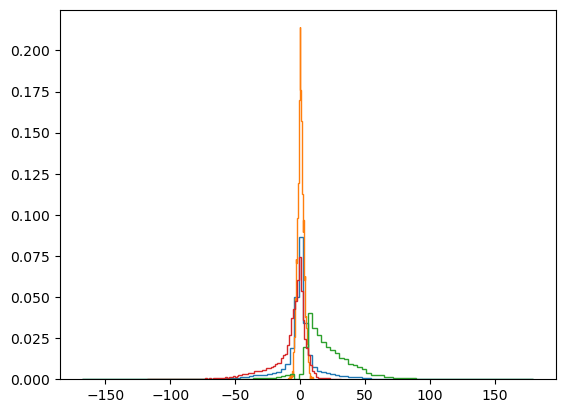

In [273]:
plt.hist(dtheta, bins=100, histtype="step", density=True);
plt.hist(dtheta[np.where(Z2==0)[0]], bins=100, histtype="step", density=True);
plt.hist(dtheta[np.where(Z2==1)[0]], bins=100, histtype="step", density=True);
plt.hist(dtheta[np.where(Z2==2)[0]], bins=100, histtype="step", density=True);

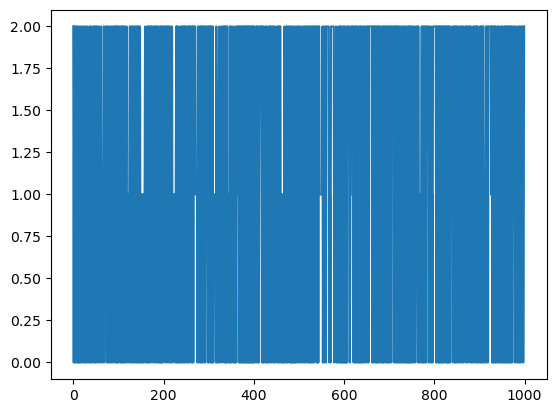

In [274]:
plt.plot(Z2[1000:2000])

In [275]:
np.unique(Z2, return_counts=True)

(array([0, 1, 2]), array([11851,  5451, 14701]))

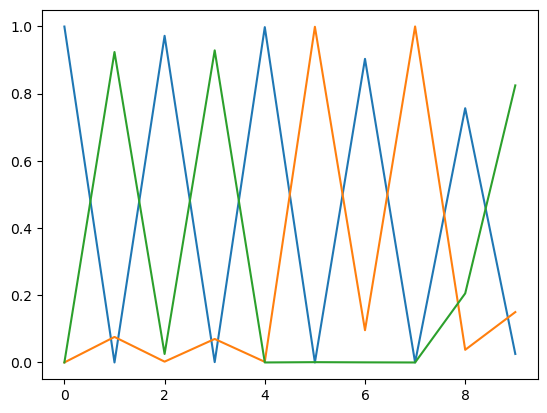

In [276]:
plt.plot(model.predict_proba(dtheta[:,np.newaxis])[:10,:])

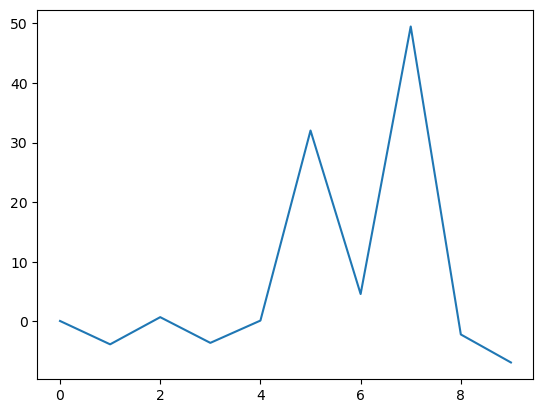

In [277]:
plt.plot(dtheta[:10])

fake trajectories by sampling from distance distribution

In [ ]:
mean squared angle to see how the angle diffuses compared to the data